## Importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
# print(os.listdir("../input"))

# Importing train datasets

In [2]:
df_id = pd.read_csv("./train_identity.csv")
df_trans = pd.read_csv("./train_transaction.csv")

### Modelling

In [3]:
df_trans = pd.read_csv('./train_transaction.csv')
df_test_trans = pd.read_csv('./test_transaction.csv')

df_id = pd.read_csv('./train_identity.csv')
df_test_id = pd.read_csv('./test_identity.csv')

sample_submission = pd.read_csv('./sample_submission.csv', index_col='TransactionID')

df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True, on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True, right_index=True, on='TransactionID')

print(df_train.shape)
print(df_test.shape)

# y_train = df_train['isFraud'].copy()
del df_trans, df_id, df_test_trans, df_test_id


(590540, 434)
(506691, 433)


# Mapping emails

In [4]:
# emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
#           'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
#           'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
#           'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
#           'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
#           'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
#           'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
#           'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
#           'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
#           'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
#           'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
#           'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
#           'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
#           'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
#           'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
#           'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
#           'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
#           'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
#           'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

# us_emails = ['gmail', 'net', 'edu']

# # https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
# for c in ['P_emaildomain', 'R_emaildomain']:
#     df_train[c + '_bin'] = df_train[c].map(emails)
#     df_test[c + '_bin'] = df_test[c].map(emails)
    
#     df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1]) # find .com, ,mx ..
#     df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
#     df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
#     df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us') 
#     # if not US,keep it as it is; if US, turn into suffix 

# Hours and Days

In [5]:
def day_encoder(df, offset = 0, colname = 'TransactionDT'):
    days = df[colname] / (3600*24)
    encode_days = np.floor(days - 1 + offset) % 7 #review
    return encode_days

def hour_encoder(df, colname = 'TransactionDT'):
    hours = df_train['TransactionDT'] / 3600
    encode_hours = np.floor(hours) % 24 #review
    return encode_hours

In [6]:
df_train['weekday'] = day_encoder(df_train, offset = 0.58)
df_test['weekday'] = day_encoder(df_test, offset=  0.58)

In [7]:
df_train['hours'] = hour_encoder(df_train)
df_test['hours'] = hour_encoder(df_test)

# Encoding categorical features

In [8]:
# Label Encoding
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))   

# Some feature engineering

In [9]:
# this is normalizing 
df_train['Trans_min_mean'] = df_train['TransactionAmt'] - df_train['TransactionAmt'].mean()
df_train['Trans_min_std'] = df_train['Trans_min_mean'] / df_train['TransactionAmt'].std()
df_test['Trans_min_mean'] = df_test['TransactionAmt'] - df_test['TransactionAmt'].mean()
df_test['Trans_min_std'] = df_test['Trans_min_mean'] / df_test['TransactionAmt'].std()

In [10]:
# df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
# df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
# df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
# df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('std')

# df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
# df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
# df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
# df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

In [11]:
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

# Concating dfs to get PCA of V features

In [12]:
df_test['isFraud'] = 'test'
df = pd.concat([df_train, df_test], axis=0, sort=False )
df = df.reset_index()
df = df.drop('index', axis=1)

In [13]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [14]:
mas_v = df_train.columns[55:394]

# Getting PCA 

In [15]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))

    
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=30)

In [16]:
# df = reduce_mem_usage(df)

# Seting train and test back

In [17]:
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

In [18]:
df_train.shape

(590540, 129)

# Seting X and y

In [19]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 
                                                      'TransactionDT', 
                                                      #'Card_ID'
                                                     ],
                                                     axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT',
                                                    #'Card_ID'
                                                   ], 
                                                   axis=1)
del df_train
df_test = df_test[["TransactionDT"]]

# LightBGM 

In [20]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb

In [21]:
param = {'num_leaves': 120,
         'metric': 'auc',
         'objective': 'binary',
         'is_unbalance': True,  
         'max_depth': -1,
         'n_estimators': 50,
         'learning_rate': 0.05,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9 ,
         "lambda_l1": 0.1,
         "verbosity": -1}

In [22]:
def train_lgb(df_train,target ,df_test,features, params) :
# define folds for cross validation
    folds= KFold(n_splits=10,random_state=820)
    oof = np.zeros(len(df_train))
    predictions=  np.zeros(len(df_test))
    features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})
    for fold, (trn_idx, val_idx) in enumerate(folds.split(df_train, target)): 
        print(" fold nb:{}".format(fold))
        train_df= lgb.Dataset(df_train.iloc[trn_idx][features], label=target[trn_idx])
        validation_df= lgb.Dataset(data=df_train.iloc[val_idx][features], label=target[val_idx])

        num_round = 500 # you might change this number 
        clf = lgb.train(params,train_df, num_round,valid_sets=[train_df,validation_df],verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx]= clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
        fold_importance_df['Feature']= features
        fold_importance_df['Importance']= clf.feature_importance()
        fold_importance_df["fold"] = fold + 1
        features_importance = pd.concat([features_importance, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    return clf, predictions, features_importance, oof

In [23]:
features = X_train.columns
clf, predictions, features_importance, oof= train_lgb(X_train, y_train.values ,X_test,features, param)

 fold nb:0


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.954092	valid_1's auc: 0.898319


C:\Users\mcui1\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




 fold nb:1


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.9525	valid_1's auc: 0.902424
 fold nb:2


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953373	valid_1's auc: 0.914923
 fold nb:3


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953665	valid_1's auc: 0.922211
 fold nb:4


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953132	valid_1's auc: 0.921803
 fold nb:5


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.955165	valid_1's auc: 0.895749
 fold nb:6


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953292	valid_1's auc: 0.927804
 fold nb:7


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953211	valid_1's auc: 0.926184
 fold nb:8


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953792	valid_1's auc: 0.91445
 fold nb:9


C:\Users\mcui1\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953985	valid_1's auc: 0.913035


In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    

Feature        object
Importance    float64
dtype: object


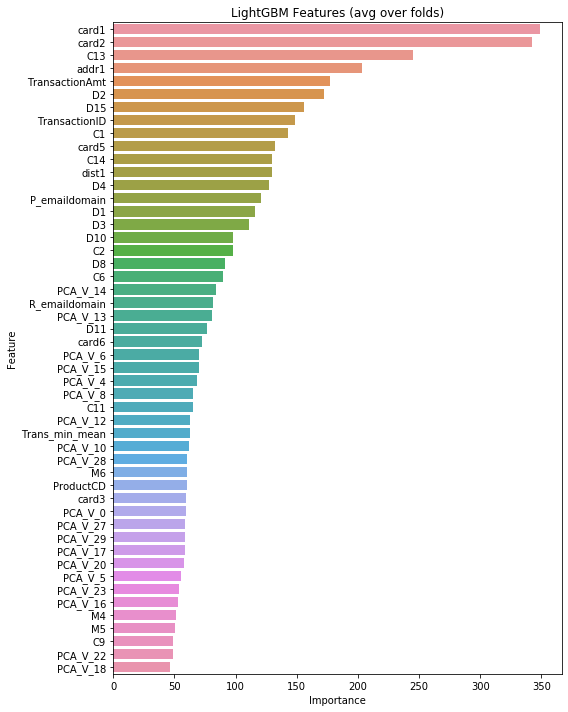

In [25]:
display_importances(features_importance)

## Seting y_pred to csv

In [26]:
sample_submission['isFraud'] = predictions
sample_submission.to_csv('LightBGM_model_Jess_08.22.19.csv')